In [2]:
# imported required modules
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in files line by line and seperate
def extractData(infile,outfile,head = True):
    line = infile.readline()
    if head == True:
        header = line
        outfile.write(header)
    line = infile.readline()
    while line:
        sline = line.split(" ")
        type3 = -1
        for elem in sline[6:]:
            if elem[:5] == "type1":
                type1 = int(elem[6:])
            elif elem[:5] == "type2":
                type2 = int(elem[6:])
            elif elem[:5] == "type3":
                type3 = int(elem[6:])
        if type1 == 14 and (type2 != 14 or (type3 !=14 and type3 >= 0)):
            outfile.write(line)
        elif type2 == 14 and (type1 != 14 or(type3 !=14 and type3 >= 0)):
            outfile.write(line)
        elif (type1 != 14 or type2 != 14) and type3 ==14:
            outfile.write(line)
        line = infile.readline()

In [4]:
# create list for black hole masses
def findSysInfo(infile,convfile):
    # zero all values
    times = []
    bhMass = []
    compMass = []
    compType = []
    ss = 0
    bs = 0
    bb = 0
    compTime = []
    
    # read in header
    line = infile.readline()
    header = line
    
    # read in data file
    line = infile.readline()
    while line:
        
        # initialize type3 since it is not guarenteed to exist
        type3 = -1
        
        # split line
        sline = line.split(" ")
        
        # find time of collision
        t = float(sline[0][2:])
        times.append(t)
        
        # grab object type data
        for elem in sline[6:]:
            if elem[:5] == "type1":
                type1 = int(elem[6:])
            elif elem[:5] == "type2":
                type2 = int(elem[6:])
            elif elem[:5] == "type3":
                type3 = int(elem[6:])
        info = sline[3].split(":")
        
        # find black hole masses
        if type1 == 14:
            smass = info[0].split("(")
            bhMass.append(float(smass[1][3:-1]))
        elif type2 == 14:
            smass = info[1].split("(")
            bhMass.append(float(smass[1][3:-1]))
        else:
            smass = info[2].split("(")
            bhMass.append(float(smass[1][3:-1]))
        
        # find mass and type of companion
        if type1 != 14:
            compType.append(type1)
            smass = info[0].split("(")
            m = float(smass[1][3:-1])
            compMass.append(float(smass[1][3:-1]))
            compTime.append(t)
        if type2 != 14:
            compType.append(type2)
            smass = info[1].split("(")
            m = float(smass[1][3:-1])
            compMass.append(m)
            compTime.append(t)
        if type3 != 14 and type3 >= 0:
            compType.append(type3)
            smass = info[2].split("(")
            m = float(smass[1][3:-1])
            compMass.append(m)
            compTime.append(t)

        # count interaction type
        if sline[1] == "single-single": 
            ss += 1
        elif sline[1] == "binary-single": 
            bs += 1
        else: 
            bb += 1
            
        # read next line
        line = infile.readline()
        
    # get conversion factors from conversion file
    convline = convfile.readline()
    while convline:
        if convline[:12] == "timeunitsmyr":
            tconvfact = float(convline[13:])
        elif convline[:13] == "mstarunitmsun":
            mconvfact = float(convline[14:])
        convline = convfile.readline()
        
    # convert times to Myrs
    for i in range(len(times)):
        times[i] = times[i] * tconvfact
        compTime[i] = compTime[i] * tconvfact
        
    # convert masses to Msun
    for i in range(len(bhMass)):
        bhMass[i] = bhMass[i] * mconvfact
    for i in range(len(compMass)):
        compMass[i] = compMass[i] * mconvfact
        
    # return lists
    return times,bhMass,compMass,compType,ss,bs,bb,compTime

In [5]:
def find_MS_turnoff(t):
        """given the time in Myr it finds the MS turn-off mass in Solar masses.  Very simple now.\
        Need to make the MS lifetime formula better. """
        t_yr = t*10**6
        lm = (9.921 - np.log10(t_yr))/3.6648
        m = 10**lm
        return m

In [6]:
def find_t_ms(z, m):
        eta = np.log10(z/0.02)
        a1 = 1.593890e3+2.053038e3*eta+1.231226e3*eta**2.+2.327785e2*eta**3.
        a2 = 2.706708e3+ 1.483131e3*eta+ 5.772723e2*eta**2.+ 7.411230e1*eta**3.
        a3 = 1.466143e2 - 1.048442e2*eta - 6.795374e1*eta**2. - 1.391127e1*eta**3.
        a4 = 4.141960e-2 + 4.564888e-2*eta + 2.958542e-2*eta**2 + 5.571483e-3*eta**3.
        a5 = 3.426349e-1
        a6 = 1.949814e1 + 1.758178*eta - 6.008212*eta**2. - 4.470533*eta**3.
        a7 = 4.903830
        a8 = 5.212154e-2 + 3.166411e-2*eta - 2.750074e-3*eta**2. - 2.271549e-3*eta**3.
        a9 = 1.312179 - 3.294936e-1*eta + 9.231860e-2*eta**2. + 2.610989e-2*eta**3.
        a10 = 8.073972e-1

        m_hook = 1.0185 + 0.16015*eta + 0.0892*eta**2.
        m_HeF = 1.995 + 0.25*eta + 0.087*eta**2.
        m_FGB = 13.048*(z/0.02)**0.06/(1+0.0012*(0.02/z)**1.27)

        t_BGB = (a1+a2*m**4.+a3*m**5.5+m**7.)/(a4*m**2.+a5*m**7.)
        x = max([0.95,min([0.95-0.03*(eta+0.30103)]),0.99])
        mu = max(0.5, 1.0-0.01* max(a6/(m**a7) , a8+a9/m**a10))
        t_hook = mu*t_BGB

        t_MS = max(t_hook, x*t_BGB)

        return (t_MS)

In [7]:
def find_MS_TO(t, z, mguess):
        tguess = find_t_ms(z, mguess)
        #print mguess, tguess, (t-tguess)/t

        while abs((t-tguess)/t) > 0.0005:
                if (t-tguess)/t > 0.0005:
                        mguess -= 0.0001
                if (t-tguess)/t < 0.0005:
                        mguess += 0.0001
                tguess = find_t_ms(z, mguess)
                #print mguess, tguess, (t-tguess)/t
        mto = mguess
        return mto

In [8]:
# open files
n2e5rv05 = open("data/N2e5binfrac100/initial.collision0.5.log")
n2e5rv06 = open("data/N2e5binfrac100/initial.collision0.6.log")
n2e5rv07 = open("data/N2e5binfrac100/initial.collision0.7.log")
n2e5rv08 = open("data/N2e5binfrac100/initial.collision0.8.log")
n2e5rv09 = open("data/N2e5binfrac100/initial.collision0.9.log")
n2e5rv10 = open("data/N2e5binfrac100/initial.collision1.log")
n2e5rv150 = open("data/N2e5binfrac100/initial.collision1.5.log")
n2e5rv175 = open("data/N2e5binfrac100/initial.collision1.75.log")
n2e5rv20 = open("data/N2e5binfrac100/initial.collision2.log")
n2e5rv3 = open("data/N2e5binfrac100/initial.collision3.log")
n2e5rv05out = open("data/N2e5binfrac100/bhstar.collision0.5.log",mode='w')
n2e5rv06out = open("data/N2e5binfrac100/bhstar.collision0.6.log",mode='w')
n2e5rv07out = open("data/N2e5binfrac100/bhstar.collision0.7.log",mode='w')
n2e5rv08out = open("data/N2e5binfrac100/bhstar.collision0.8.log",mode='w')
n2e5rv09out = open("data/N2e5binfrac100/bhstar.collision0.9.log",mode='w')
n2e5rv10out = open("data/N2e5binfrac100/bhstar.collision1.log",mode='w')
n2e5rv150out = open("data/N2e5binfrac100/bhstar.collision1.5.log",mode='w')
n2e5rv175out = open("data/N2e5binfrac100/bhstar.collision1.75.log",mode='w')
n2e5rv20out = open("data/N2e5binfrac100/bhstar.collision2.log",mode='w')
n2e5rv3out = open("data/N2e5binfrac100/bhstar.collision3.log",mode='w')

In [9]:
extractData(n2e5rv05,n2e5rv05out)
extractData(n2e5rv06,n2e5rv06out)
extractData(n2e5rv07,n2e5rv07out)
extractData(n2e5rv08,n2e5rv08out)
extractData(n2e5rv09,n2e5rv09out)
extractData(n2e5rv10,n2e5rv10out)
extractData(n2e5rv150,n2e5rv150out)
extractData(n2e5rv175,n2e5rv175out)
extractData(n2e5rv20,n2e5rv20out)
extractData(n2e5rv3,n2e5rv3out)

In [10]:
# close files
n2e5rv05.close()
n2e5rv06.close()
n2e5rv07.close()
n2e5rv08.close()
n2e5rv09.close()
n2e5rv10.close()
n2e5rv150.close()
n2e5rv175.close()
n2e5rv20.close()
n2e5rv3.close()
n2e5rv05out.close()
n2e5rv06out.close()
n2e5rv07out.close()
n2e5rv08out.close()
n2e5rv09out.close()
n2e5rv10out.close()
n2e5rv150out.close()
n2e5rv175out.close()
n2e5rv20out.close()
n2e5rv3out.close()

In [11]:
n2e5rv05out = open("data/N2e5binfrac100/bhstar.collision0.5.log",mode='r')
n2e5rv06out = open("data/N2e5binfrac100/bhstar.collision0.6.log",mode='r')
n2e5rv07out = open("data/N2e5binfrac100/bhstar.collision0.7.log",mode='r')
n2e5rv08out = open("data/N2e5binfrac100/bhstar.collision0.8.log",mode='r')
n2e5rv09out = open("data/N2e5binfrac100/bhstar.collision0.9.log",mode='r')
n2e5rv10out = open("data/N2e5binfrac100/bhstar.collision1.log",mode='r')
n2e5rv150out = open("data/N2e5binfrac100/bhstar.collision1.5.log",mode='r')
n2e5rv175out = open("data/N2e5binfrac100/bhstar.collision1.75.log",mode='r')
n2e5rv20out = open("data/N2e5binfrac100/bhstar.collision2.log",mode='r')
n2e5rv3out = open("data/N2e5binfrac100/bhstar.collision3.log",mode='r')
n2e5conv05 = open("data/N2e5binfrac100/initial.conv0.5.sh")
n2e5conv06 = open("data/N2e5binfrac100/initial.conv0.6.sh")
n2e5conv07 = open("data/N2e5binfrac100/initial.conv0.7.sh")
n2e5conv08 = open("data/N2e5binfrac100/initial.conv0.8.sh")
n2e5conv09 = open("data/N2e5binfrac100/initial.conv0.9.sh")
n2e5conv10 = open("data/N2e5binfrac100/initial.conv1.sh")
n2e5conv150 = open("data/N2e5binfrac100/initial.conv1.5.sh")
n2e5conv175 = open("data/N2e5binfrac100/initial.conv1.75.sh")
n2e5conv20 = open("data/N2e5binfrac100/initial.conv2.sh")
n2e5conv3 = open("data/N2e5binfrac100/initial.conv3.sh")

In [12]:
n2e5time05,n2e5bhMass05,n2e5compMass05,n2e5compType05,n2e5ss05,n2e5bs05,n2e5bb05,n2e5compTime05 = \
    findSysInfo(n2e5rv05out,n2e5conv05)
n2e5time06,n2e5bhMass06,n2e5compMass06,n2e5compType06,n2e5ss06,n2e5bs06,n2e5bb06,n2e5compTime06 = \
    findSysInfo(n2e5rv06out,n2e5conv06)
n2e5time07,n2e5bhMass07,n2e5compMass07,n2e5compType07,n2e5ss07,n2e5bs07,n2e5bb07,n2e5compTime07 = \
    findSysInfo(n2e5rv07out,n2e5conv07)
n2e5time08,n2e5bhMass08,n2e5compMass08,n2e5compType08,n2e5ss08,n2e5bs08,n2e5bb08,n2e5compTime08 = \
    findSysInfo(n2e5rv08out,n2e5conv08)
n2e5time09,n2e5bhMass09,n2e5compMass09,n2e5compType09,n2e5ss09,n2e5bs09,n2e5bb09,n2e5compTime09 = \
    findSysInfo(n2e5rv09out,n2e5conv09)
n2e5time10,n2e5bhMass10,n2e5compMass10,n2e5compType10,n2e5ss10,n2e5bs10,n2e5bb10,n2e5compTime10 = \
    findSysInfo(n2e5rv10out,n2e5conv10)
n2e5time150,n2e5bhMass150,n2e5compMass150,n2e5compType150,n2e5ss150,n2e5bs150,n2e5bb150,n2e5compTime150 = \
    findSysInfo(n2e5rv150out,n2e5conv150)
n2e5time175,n2e5bhMass175,n2e5compMass175,n2e5compType175,n2e5ss175,n2e5bs175,n2e5bb175,n2e5compTime175 = \
    findSysInfo(n2e5rv175out,n2e5conv175)
n2e5time20,n2e5bhMass20,n2e5compMass20,n2e5compType20,n2e5ss20,n2e5bs20,n2e5bb20,n2e5compTime20 = \
    findSysInfo(n2e5rv20out,n2e5conv20)
n2e5time3,n2e5bhMass3,n2e5compMass3,n2e5compType3,n2e5ss3,n2e5bs3,n2e5bb3,n2e5compTime3 = \
    findSysInfo(n2e5rv3out,n2e5conv3)

In [13]:
# close files
n2e5rv05.close()
n2e5rv06.close()
n2e5rv07.close()
n2e5rv08.close()
n2e5rv09.close()
n2e5rv10.close()
n2e5rv150.close()
n2e5rv175.close()
n2e5rv20.close()
n2e5rv3.close()
n2e5conv05.close()
n2e5conv06.close()
n2e5conv07.close()
n2e5conv08.close()
n2e5conv09.close()
n2e5conv10.close()
n2e5conv150.close()
n2e5conv175.close()
n2e5conv20.close()
n2e5conv3.close()

In [14]:
# combine lists into poor, rich, and intermediate groups
n2e5timepr = n2e5time05 + n2e5time06 + n2e5time07
n2e5timeint = n2e5time08 + n2e5time09 + n2e5time10
n2e5timerch = n2e5time3 + n2e5time150 + n2e5time175 + n2e5time20

n2e5bhMasspr = n2e5bhMass05 + n2e5bhMass06 + n2e5bhMass07
n2e5bhMassint = n2e5bhMass08 + n2e5bhMass09 + n2e5bhMass10
n2e5bhMassrch = n2e5bhMass3 + n2e5bhMass150 + n2e5bhMass175 + n2e5bhMass20

n2e5compMasspr = n2e5compMass05 + n2e5compMass06 + n2e5compMass07
n2e5compMassint = n2e5compMass08 + n2e5compMass09 + n2e5compMass10
n2e5compMassrch = n2e5compMass3 + n2e5compMass150 + n2e5compMass175 + n2e5compMass20

n2e5compTypepr = n2e5compType05 + n2e5compType06 + n2e5compType07
n2e5compTypeint = n2e5compType08 + n2e5compType09 + n2e5compType10
n2e5compTyperch = n2e5compType3 + n2e5compType150 + n2e5compType175 + n2e5compType20

n2e5sspr = n2e5ss05 + n2e5ss06 + n2e5ss07
n2e5ssint = n2e5ss08 + n2e5ss09 + n2e5ss10
n2e5ssrch = n2e5ss3 + n2e5ss150 + n2e5ss175 + n2e5ss20

n2e5bspr = n2e5bs05 + n2e5bs06 + n2e5bs07
n2e5bsint = n2e5bs08 + n2e5bs09 + n2e5bs10
n2e5bsrch = n2e5bs3 + n2e5bs150 + n2e5bs175 + n2e5bs20

n2e5bbpr = n2e5bb05 + n2e5bb06 + n2e5bb07
n2e5bbint = n2e5bb08 + n2e5bb09 + n2e5bb10
n2e5bbrch = n2e5bb3 + n2e5bb150 + n2e5bb175 + n2e5bb20

n2e5compTimepr = n2e5compTime05 + n2e5compTime06 + n2e5compTime07
n2e5compTimeint = n2e5compTime08 + n2e5compTime09 + n2e5compTime10
n2e5compTimerch = n2e5compTime3 + n2e5compTime150 + n2e5compTime175 + n2e5compTime20

n2e5AllCompTime = n2e5compTimeint + n2e5compTimepr + n2e5compTimerch
n2e5AllCompMass = n2e5compMassint + n2e5compMasspr + n2e5compMassrch

In [15]:
# make each list an array in numpy
n2e5timepr = np.array(n2e5timepr)
n2e5timeint = np.array(n2e5timeint)
n2e5timerch = np.array(n2e5timerch)

n2e5bhMasspr = np.array(n2e5bhMasspr)
n2e5bhMassint = np.array(n2e5bhMassint)
n2e5bhMassrch = np.array(n2e5bhMassrch)

n2e5compMasspr = np.array(n2e5compMasspr)
n2e5compMassint = np.array(n2e5compMassint)
n2e5compMassrch = np.array(n2e5compMassrch)

n2e5compTypepr = np.array(n2e5compTypepr)
n2e5compTypeint = np.array(n2e5compTypeint)
n2e5compTyperch = np.array(n2e5compTyperch)

n2e5compTimepr = np.array(n2e5compTimepr)
n2e5compTimeint = np.array(n2e5compTimeint)
n2e5compTimerch = np.array(n2e5compTimerch)

n2e5AllCompTime = np.array(n2e5AllCompTime)
n2e5AllCompMass = np.array(n2e5AllCompMass)

<IPython.core.display.Javascript object>


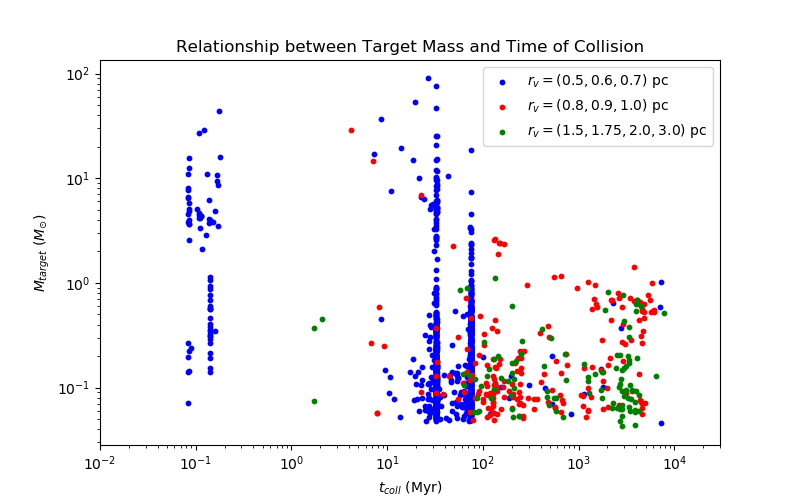

In [22]:
f,ax = plt.subplots(figsize=(8,5))

# t = np.logspace(0.05,4.25,num=20)
# mto = []
# for time in t:
#     mto.append(find_MS_TO(time,0.001,find_MS_turnoff(time)))
# ax.plot(t,mto,label="MS Turnoff Mass")

ax.scatter(n2e5compTimepr,n2e5compMasspr,c='b',label='$r_v = (0.5,0.6,0.7)$ pc',s=10)
ax.scatter(n2e5compTimeint,n2e5compMassint,c='r',label='$r_v = (0.8,0.9,1.0)$ pc',s=10)
ax.scatter(n2e5compTimerch,n2e5compMassrch,c='g',label='$r_v = (1.5,1.75,2.0,3.0)$ pc',s=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Relationship between Target Mass and Time of Collision")
ax.set_xlabel("$t_{coll}$ (Myr)")
ax.set_ylabel("$M_{target}$ ($M_{\odot}$)")
ax.set_xlim(0.01,30000)
ax.legend()

In [23]:
f,ax = plt.subplots(figsize=(8,5))

# t = np.logspace(0.05,4.25,num=20)
# mto = []
# for time in t:
#     mto.append(find_MS_TO(time,0.001,find_MS_turnoff(time)))
# ax.plot(t,mto,label="MS Turnoff Mass")

ax.scatter(n2e5compTimepr,n2e5compMasspr,c='b',label='$r_v = (0.5,0.6,0.7)$ pc',s=10)
ax.scatter(n2e5compTimeint,n2e5compMassint,c='r',label='$r_v = (0.8,0.9,1.0)$ pc',s=10)
ax.scatter(n2e5compTimerch,n2e5compMassrch,c='g',label='$r_v = (1.5,1.75,2.0,3.0)$ pc',s=10)

t = np.logspace(0.05,4.25,num=20)
mto = []
for time in t:
    mto.append(find_MS_TO(time,0.001,find_MS_turnoff(time)))
ax.plot(t,mto,label="MS Turnoff Mass")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Relationship between Target Mass and Time of Collision")
ax.set_xlabel("$t_{coll}$ (Myr)")
ax.set_ylabel("$M_{target}$ ($M_{\odot}$)")
ax.set_xlim(0.01,30000)
ax.legend()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [25]:
n2e5rv05 = open("data/initial.collision0.5.log")
n2e5rv20 = open("data/initial.collision2.log")
n2e5rv05out = open("data/bhstar.collision0.5.log",mode='w')
n2e5rv20out = open("data/bhstar.collision2.log",mode='w')

In [26]:
extractData(n2e5rv05,n2e5rv05out)
extractData(n2e5rv20,n2e5rv20out)

In [27]:
n2e5rv05.close()
n2e5rv20.close()
n2e5rv05out.close()
n2e5rv20out.close()

In [28]:
n2e5rv05out = open("data/bhstar.collision0.5.log",mode='r')
n2e5rv20out = open("data/bhstar.collision2.log",mode='r')
n2e5conv05 = open("data/initial.conv0.5.sh")
n2e5conv20 = open("data/initial.conv2.sh")

In [29]:
n2e5time05,n2e5bhMass05,n2e5compMass05,n2e5compType05,n2e5ss05,n2e5bs05,n2e5bb05,n2e5compTime05 = \
    findSysInfo(n2e5rv05out,n2e5conv05)
n2e5time20,n2e5bhMass20,n2e5compMass20,n2e5compType20,n2e5ss20,n2e5bs20,n2e5bb20,n2e5compTime20 = \
    findSysInfo(n2e5rv20out,n2e5conv20)

In [30]:
n2e5rv05.close()
n2e5rv20.close()
n2e5conv05.close()
n2e5conv20.close()

<IPython.core.display.Javascript object>


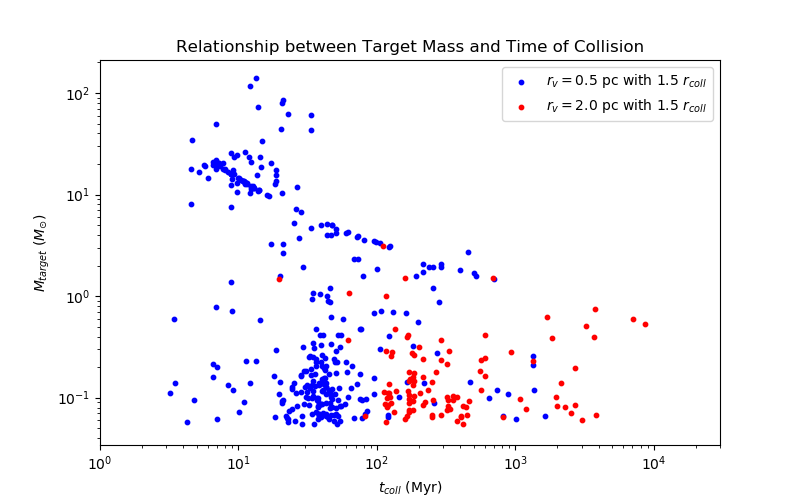

In [36]:
f,ax = plt.subplots(figsize=(8,5))

# t = np.logspace(0.05,4.25,num=20)
# mto = []
# for time in t:
#     mto.append(find_MS_TO(time,0.001,find_MS_turnoff(time)))
# ax.plot(t,mto,label="MS Turnoff Mass")

ax.scatter(n2e5compTime05,n2e5compMass05,c='b',label='$r_v = 0.5$ pc with 1.5 $r_{coll}$',s=10)
ax.scatter(n2e5compTime20,n2e5compMass20,c='r',label='$r_v = 2.0$ pc with 1.5 $r_{coll}$',s=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Relationship between Target Mass and Time of Collision")
ax.set_xlabel("$t_{coll}$ (Myr)")
ax.set_ylabel("$M_{target}$ ($M_{\odot}$)")
ax.set_xlim(1,30000)
ax.legend()

In [39]:
print(len(n2e5time05))
print(len(n2e5time20))

328
107


In [58]:
rv05 = open("data/poorBH/initial.collision0.5.log")
rv20 = open("data/richBH/initial.collision2.log")
rv05out = open("data/poorBH/bhstar.collision0.5.log",mode='w')
rv20out = open("data/richBH/bhstar.collision2.log",mode='w')

In [59]:
extractData(rv05,rv05out)
extractData(rv20,rv20out)

In [60]:
rv05.close()
rv20.close()
rv05out.close()
rv20out.close()

In [61]:
rv05out = open("data/poorBH/bhstar.collision0.5.log")
rv20out = open("data/richBH/bhstar.collision2.log")
conv05 = open("data/poorBH/initial.conv0.5.sh")
conv20 = open("data/richBH/initial.conv2.sh")

In [62]:
time05,bhMass05,compMass05,compType05,ss05,bs05,bb05,compTime05 = findSysInfo(rv05out,conv05)
time20,bhMass20,compMass20,compType20,ss20,bs20,bb20,compTime20 = findSysInfo(rv20out,conv20)

In [63]:
rv05.close()
rv20.close()
conv05.close()
conv20.close()

In [64]:
compTime05 = np.array(compTime05)
compMass05 = np.array(compMass05)

compTime20 = np.array(compTime20)
compMass20 = np.array(compMass20)

<IPython.core.display.Javascript object>


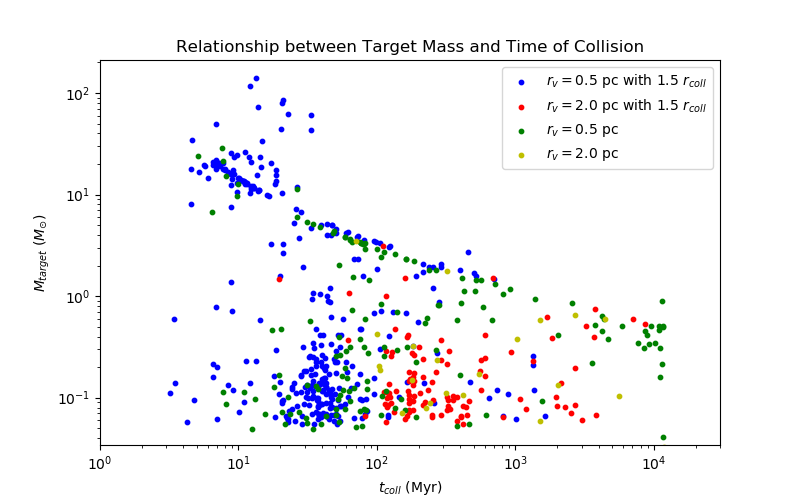

In [65]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(n2e5compTime05,n2e5compMass05,c='b',label='$r_v = 0.5$ pc with 1.5 $r_{coll}$',s=10)
ax.scatter(n2e5compTime20,n2e5compMass20,c='r',label='$r_v = 2.0$ pc with 1.5 $r_{coll}$',s=10)
ax.scatter(compTime05,compMass05,c='g',label='$r_v = 0.5$ pc',s=10)
ax.scatter(compTime20,compMass20,c='y',label='$r_v = 2.0$ pc',s=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Relationship between Target Mass and Time of Collision")
ax.set_xlabel("$t_{coll}$ (Myr)")
ax.set_ylabel("$M_{target}$ ($M_{\odot}$)")
ax.set_xlim(1,30000)
ax.legend()

<IPython.core.display.Javascript object>


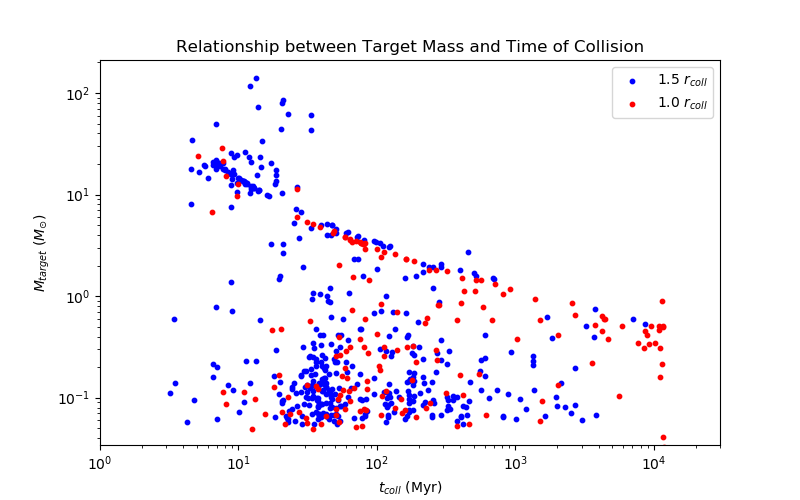

In [66]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(n2e5compTime05,n2e5compMass05,c='b',label='1.5 $r_{coll}$',s=10)
ax.scatter(n2e5compTime20,n2e5compMass20,c='b',s=10)
ax.scatter(compTime05,compMass05,c='r',label='1.0 $r_{coll}$',s=10)
ax.scatter(compTime20,compMass20,c='r',s=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Relationship between Target Mass and Time of Collision")
ax.set_xlabel("$t_{coll}$ (Myr)")
ax.set_ylabel("$M_{target}$ ($M_{\odot}$)")
ax.set_xlim(1,30000)
ax.legend()